In [90]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model

In [91]:
# get training and validation(=testing) data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../COMP_473_Project/TrainSet1-new',
    image_size = (48,48), # our original dataset is 48 pixels by 48 pixels
    batch_size = 12, # pick 12 images and trim until all dataset is used <= repeat this for each epoche
    color_mode='grayscale'
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../COMP_473_Project/TestSet1-new',
    image_size = (48,48), 
    batch_size = 12,
    color_mode='grayscale'
)


Found 2760 files belonging to 7 classes.
Found 1440 files belonging to 7 classes.


In [92]:
train_ds 
# form shape=(None, 48, 48, 3) <- 3 represent that the photo is treated as colored. one pixel will have [R G B] values between 0~255

<BatchDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

tf.Tensor(
[[[[ 0.]
   [ 0.]
   [ 0.]
   ...
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ...
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ...
   [ 0.]
   [ 0.]
   [ 0.]]

  ...

  [[ 0.]
   [ 0.]
   [ 0.]
   ...
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ...
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ...
   [ 0.]
   [ 0.]
   [ 0.]]]


 [[[85.]
   [86.]
   [88.]
   ...
   [14.]
   [29.]
   [79.]]

  [[85.]
   [85.]
   [83.]
   ...
   [21.]
   [11.]
   [46.]]

  [[85.]
   [86.]
   [74.]
   ...
   [23.]
   [14.]
   [23.]]

  ...

  [[63.]
   [66.]
   [66.]
   ...
   [38.]
   [46.]
   [62.]]

  [[63.]
   [64.]
   [64.]
   ...
   [36.]
   [45.]
   [61.]]

  [[61.]
   [62.]
   [64.]
   ...
   [35.]
   [49.]
   [65.]]]


 [[[ 0.]
   [ 0.]
   [ 0.]
   ...
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ...
   [ 0.]
   [ 0.]
   [ 0.]]

  [[ 0.]
   [ 0.]
   [ 0.]
   ...
   [ 0.]
   [ 0.]
   [ 0.]]

  ...

  [[ 0.]
   [ 0.]
 

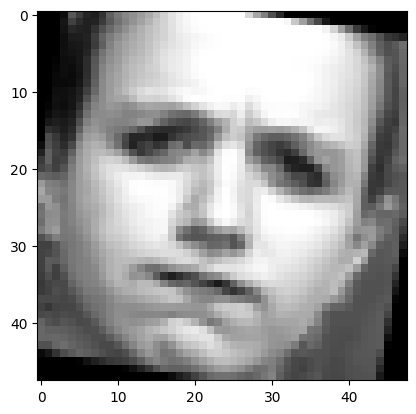

'In a grayscale image where there is only one channel, a pixel value has just a single number ranging from 0 to 255 (both inclusive).\n The pixel value 0 represents black and the pixel value 255 represents white.\n [ 80.] is closer to black than white therefore showing black'

In [93]:
# try to output one of our image

for i, answer in train_ds.take(1): #take(1): takes first batch. 

  print(i) # outputs 12(=batch size) photos as numpy array ,shape=(12, 48, 48, 3) means 12 photos, each photo size(48,48 pixels), 3=color= each cell represented as [R G B]
  print(answer) # outputs correct answer for current batch [ 5 2 6 ...] <- first photo in this batch is in class 5, second photo in this patch is in class 2.. 

plt.imshow(i[0].numpy().astype('uint8'), cmap='gray', vmin=0, vmax=255) # output the first photo using matplotlib
plt.show()
'''In a grayscale image where there is only one channel, a pixel value has just a single number ranging from 0 to 255 (both inclusive).
 The pixel value 0 represents black and the pixel value 255 represents white.
 [ 80.] is closer to black than white therefore showing black'''


In [94]:
# preprocess colored data
# since the numbers are between 0~255 for each R, G, and B, it is slower to train and calculate weights.
# it is better to divide each number with 255, so each value resides within 0~1



def processGrayScaleData(i, answer):
  i=tf.cast(i/255.0, tf.float32) # divide i by 255, resulting data type should be float
  return i, answer

train_ds = train_ds.map(processGrayScaleData)
val_ds = val_ds.map(processGrayScaleData)

In [95]:
# try to output our image if 'processColoredData' function is working well.
for i, answer in train_ds.take(1): #take first batch 
  print(i) # now you can see that the values are compressed btw 0~1


tf.Tensor(
[[[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]]


 [[[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  ...

  [[0.        ]
   [0.      

In [96]:
# making model
model = tf.keras.Sequential([
    

    # .conv2D : with feature extraction we can expect higher accuracy               
    # 1st param: make 32 different features. use such features to train better model. 
    # 2nd param: kernel size is 3x3
    # 3rd param: when using convolutional layer, (=when kernel is applied to each photo) the size of photo will shrink. we will put some padding here to retain 48*48 size even after feature extraction.
    # 4th param: activation function. relu compress number to 0~1. There's no negative number in photo so it is good to use relu.
    # 5th param: input_shape : shape of one photo data
    tf.keras.layers.Conv2D( 32, (3,3), padding='same' , activation='relu', input_shape=(48,48,1)), # set input_shape=(48,48,3) from 3 to 1 since we are passing in grayscale
    
    
    # pooling layer (Downsampling)
    # downsize 2,2 pixels to 1,1
    tf.keras.layers.MaxPooling2D((2,2)),

    # helps prevent overfittng ( randomly sets input units to 0 with frequency of rate)
    tf.keras.layers.Dropout(0.2), 

    # It is okay to repeat [Conv-Pooling] several times
    # we will repeat [Conv-Pooling] two more times to increase learning effect
    tf.keras.layers.Conv2D( 64, (3,3), padding='same' , activation='relu'), 
    tf.keras.layers.MaxPooling2D((2,2)), 
        
    tf.keras.layers.Conv2D( 128, (3,3), padding='same' , activation='relu'), 
    tf.keras.layers.MaxPooling2D((2,2)), 


    # Flatten-Dense
    tf.keras.layers.Flatten(), 
    ## 1st layer
    tf.keras.layers.Dense(64, activation="relu"), # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dropout(0.2), # helps prevent overfittng
    ## second layer. we must have 7 final nodes because we have 7 classes.
    tf.keras.layers.Dense(7, activation="softmax") # softmax: compress resulting number between 0~1, used in category problems. If you add up the probability of each class we get 1. 
])





# prints summary of our model. 
model.summary()


# compile and fit our model
# epochs tells us the number of times model will be trained in forward and backward pass.
# validation_data is used to feed the validation/test data into the model.
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam" , metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=10)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 12, 12, 128)      

#### Save model weights

In [97]:
model.save('model_saved.h5')

## Predicting a test set:

In [98]:
model = load_model('../COMP_473_Project/model_saved.h5')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../COMP_473_Project/TestSet2-new',
    image_size = (48,48),
    batch_size = 12,
    color_mode='grayscale'
)

test_ds = test_ds.map(processGrayScaleData)

Found 1440 files belonging to 7 classes.


In [99]:
# Test to see if output is okay
for i, answer in test_ds.take(1): #take first batch
  print(i)

tf.Tensor(
[[[[0.        ]
   [0.        ]
   [0.19215687]
   ...
   [0.        ]
   [0.        ]
   [0.        ]]

  [[0.        ]
   [0.01960784]
   [0.19607843]
   ...
   [0.04705882]
   [0.03529412]
   [0.02352941]]

  [[0.        ]
   [0.03137255]
   [0.20784314]
   ...
   [0.16862746]
   [0.23921569]
   [0.26666668]]

  ...

  [[1.        ]
   [0.99215686]
   [0.9098039 ]
   ...
   [0.99215686]
   [0.2509804 ]
   [0.        ]]

  [[0.        ]
   [0.09411765]
   [0.14117648]
   ...
   [1.        ]
   [0.15686275]
   [0.        ]]

  [[0.        ]
   [0.        ]
   [0.        ]
   ...
   [1.        ]
   [0.09411765]
   [0.        ]]]


 [[[0.85882354]
   [0.85882354]
   [0.8627451 ]
   ...
   [0.15686275]
   [0.3529412 ]
   [0.6313726 ]]

  [[0.8627451 ]
   [0.85490197]
   [0.8392157 ]
   ...
   [0.13725491]
   [0.15686275]
   [0.4862745 ]]

  [[0.8509804 ]
   [0.8509804 ]
   [0.8235294 ]
   ...
   [0.12941177]
   [0.14901961]
   [0.20784314]]

  ...

  [[0.7019608 ]
   [0.690196

#### Predicting the test dataset

In [100]:
# from keras.utils import load_img
#
# image = load_img('../COMP_473_Project/TestSet2-new/anger/S066_005_00000009n1.png', target_size=(48, 48))
# img = np.array(image)
# img = img / 255.0
# img = img.reshape(1,48,48,1)
# label = model.predict(img)
# print("Predicted Class (0 - Cars , 1- Planes): ", label[0][0])


for img in test_ds:
    label = model.predict(img[0])
    print(label[0][0])

1/1 [==============================] - 0s 41ms/step
3.679374e-07
1/1 [==============================] - 0s 16ms/step
8.2944305e-17
1/1 [==============================] - 0s 14ms/step
1.0014624e-08
1/1 [==============================] - 0s 15ms/step
2.0888673e-11
1/1 [==============================] - 0s 16ms/step
6.461513e-08
1/1 [==============================] - 0s 15ms/step
0.9994973
1/1 [==============================] - 0s 14ms/step
0.9976903
1/1 [==============================] - 0s 14ms/step
0.9999696
1/1 [==============================] - 0s 16ms/step
5.6525257e-10
1/1 [==============================] - 0s 15ms/step
0.0010337534
1/1 [==============================] - 0s 14ms/step
1.7250706e-17
1/1 [==============================] - 0s 14ms/step
8.8805785e-07
1/1 [==============================] - 0s 14ms/step
1.7120208e-14
1/1 [==============================] - 0s 14ms/step
1.8353178e-19
1/1 [==============================] - 0s 15ms/step
4.15504e-11
1/1 [======================